### Loading required libraries

In [2]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import os


# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

# Model Building
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import Callback
import tensorflow as tf

### Functions

In [4]:
def extract_stations(dir_raw, country='US', state='HI'):
    """
    Load weather stations in the specified region using isd-history.csv.
    :param country:
    :param state:
    :return df_stations:        pandas data frame
    """
    
    if not os.path.exists(dir_raw):
        os.makedirs(dir_raw)
    stations_csv_file = '%s/data/isd-history.csv' % dir_raw

    df = pd.read_csv(stations_csv_file)
    i_ctry = df['CTRY'] == country if country else True
    i_state = df['STATE'] == state if state else True
    df_stations = df.loc[i_ctry & i_state]
    return df_stations


def isd_to_df(filename, state):
    """
    convert_to_df(filename)
    Read in a automated weather stations data from file.
    Data is space separated columns, with format given in
    "isd-lite-format.txt".
    Converts to pandas dataframe using date/time columns as DateTimeIndex.
    Format info:
    1: Year
    2: Month
    3: Day
    4: Hour
    5: Temperature (x10) in celcius
    6: Dew point temperature (x10) in celcius
    7: Sea level pressure (x10 in hectopascals)
    8: Wind direction (degrees from north)
    9: Wind speed (x10 in meters per second)
    10: Cloud Coverage (categorical)
    11: Precipitation for One Hour (x10, in mm)
    12: Precipitation total for Six hours (x10 in mm)
    All missing values are -9999.
    """
    #use fixed width format to read in (isd-lite-format has data format)
    col_names = ['year','month','day','hour',
               'Temp','DewTemp','Pressure',
               'WindDir','WindSpeed','CloudCover',
               'Precip-1hr','Precip-6hr']
    df = pd.read_fwf(filename, compression='gzip',
                   na_values=['-9999','999'], names=col_names)

    #make a time index.
    times = pd.to_datetime({'year':df['year'],
                          'month':df['month'],
                          'day':df['day'],
                          'hour':df['hour']})
    Tindex = pd.DatetimeIndex(times)
    df.index = Tindex
    #delete those columns
    df = df.drop(labels=['year','month','day','hour'],axis=1)
    return df

def get_local_isd_path(yearstr, usaf, wban):
    return "/Volumes/isd-lite/{0}/{1}-{2:0>5}-{0}.gz".format(yearstr,str(usaf),str(wban))

def read_data(station_df, years=['2015','2016','2017']):
    """convert_all_isd(air_df)
    convert the weather files for a particular state into
    one big data frame.
    """
    df_tot = pd.DataFrame()
    tmp = [df_tot]

    #select out only the entries for the desired state.
    for i in range(len(station_df)):
        for yearstr in years:
            ap = station_df.iloc[i]
            usaf = ap['USAF']
            wban = ap['WBAN']
            state = ap['STATE']
            try:
                file_name = get_local_isd_path(yearstr, usaf, wban)
                df = isd_to_df(file_name, state)
                print(f'processing {file_name}')
                tmp.append(df)
                df_tot = pd.concat(tmp)
            except:
                continue
    return df_tot

def plot_train_points(df, quantity='Temp',Tp=None):
    plt.figure(figsize=(15,4))
    plt.title(f"{quantity} of first {Tp} data points",fontsize=16)
    plt.plot(df[quantity][:Tp],c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def create_single_variable_data(dataset, start_idx , end_idx , history_size, target_size,
                           single_step=True):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    if single_step:
      labels.append(dataset[i+target_size])
    else:
      labels.append(dataset[i:i+target_size])

  return np.array(data), np.array(labels)


def create_multiple_variable_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

# Moving window average
def MWA(history):
  return np.mean(history)


# create time steps
def create_time_steps(length):
  return list(range(-length,0))

# plot time series data
def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'gP']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])
  plt.xlabel('Time_Step')
  plt.grid()

  return plt


## Reading station data from isd-history.csv.
This function returns dataframe with USAF and WBAN number for Hawaii state stations which will help us to read USAF-WBAN-YEAR file from isd-lite directory.

In [ ]:
stations = extract_stations(dir_raw='/Volumns/',country='US', state='HI')


## Reading isd-lite data as pandas dataframe for Hawaii stations.

In [ ]:
years = ['2016','2017','2018','2019','2020','2021']
df_tot = read_data(station_df = stations, years=years)


## Saving above dataframe as csv file.

In [ ]:
df_tot.to_csv('/Volumns/data_hawai.csv')

## Getting data for single variable precipitation forcasting model 
We also clean data to drop 9999 and nulls.

In [7]:
df_tot = pd.read_csv('/Volumns/data_hawai.csv', index_col=0)
df_tot.sort_index(inplace=True) 
dt_precipitation_6hr = df_tot[df_tot['Precip-6hr']!=9999.0]
dt_precipitation_6hr = dt_precipitation_6hr.groupby(level=0)['Temp','DewTemp','Pressure','WindDir','WindSpeed','CloudCover','Precip-1hr','Precip-6hr'].mean()
dt_precipitation_6hr = dt_precipitation_6hr[['Precip-6hr']]
dt_precipitation_6hr.interpolate(inplace=True)
dt_precipitation_6hr.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [8]:
dt_precipitation_6hr.head(20)

,Precip-6hr
2017-01-01 00:00:00,190.000000
2017-01-01 01:00:00,159.875000
2017-01-01 02:00:00,129.750000
2017-01-01 03:00:00,99.625000
2017-01-01 04:00:00,69.500000
2017-01-01 05:00:00,39.375000
2017-01-01 06:00:00,9.250000
2017-01-01 07:00:00,8.583333
2017-01-01 08:00:00,7.916667
2017-01-01 09:00:00,7.250000


## Single Variable precipitation total for 6 hours forecasting model
We will train a LSTM model on single precipitation sequence data to predict future precipitation.

## Cleaning data for single variable forcasting analysis

In [9]:
uni_data = dt_precipitation_6hr.values
# train test split for simple time series moving window average
train_split = round(len(dt_precipitation_6hr)*.6)
test_split = train_split + round(round(len(dt_precipitation_6hr)*.4)*.5)
tf.random.set_seed(13)

# standardize data
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std


## Split dataset into train & test

Moving Window Average

1. Given last 50 values of observations(temp) , predict next observation
2. MWA: predict== AVG(last 50 values)

In [10]:
uni_data_history = 50   # last 20 values
uni_data_future = 0     # future data
x_train_uni , y_train_uni = create_single_variable_data(uni_data , 0 , train_split , uni_data_history , uni_data_future, single_step=True)
x_val_uni , y_val_uni = create_single_variable_data(uni_data , train_split , test_split ,uni_data_history , uni_data_future, single_step=True)
x_test_uni , y_test_uni = create_single_variable_data(uni_data , test_split , None ,uni_data_history , uni_data_future, single_step=True)



In [11]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)
print(x_test_uni.shape , y_test_uni.shape)

(26244, 50, 1) (26244, 1)
(8715, 50, 1) (8715, 1)
(8715, 50, 1) (8715, 1)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

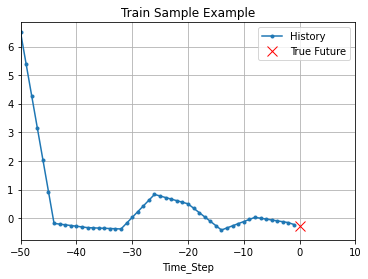

In [12]:
plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Train Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

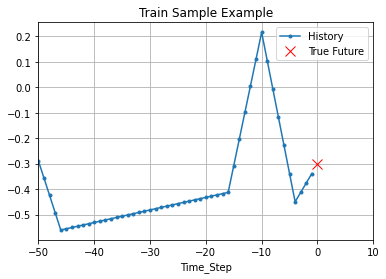

In [13]:
i = 50
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Train Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

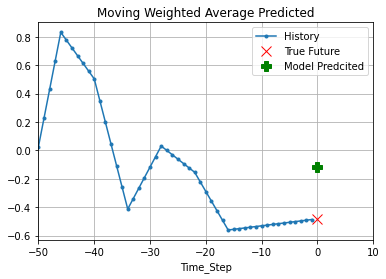

In [14]:

i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'Moving Weighted Average Predicted')

## Single variable time-series forecasting

1. Only single feature as precipitation 6 hrs(historical data)
2. Task: Given last 50 observations(history) , predict next precipitation 6 hrs value

In [16]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

test_uni = tf.data.Dataset.from_tensor_slices((x_test_uni , y_test_uni))
test_uni = test_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()


print(train_uni)
print(val_uni)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 50, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 50, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [17]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])
lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 300
epochs = 20

lstm_model.fit(train_uni , epochs = epochs, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)

Epoch 1/20
300/300 [==============================] - 13s 35ms/step - loss: 0.2330 - val_loss: 0.0957
Epoch 2/20
300/300 [==============================] - 10s 33ms/step - loss: 0.0758 - val_loss: 0.0671
Epoch 3/20
300/300 [==============================] - 10s 32ms/step - loss: 0.0616 - val_loss: 0.0592
Epoch 4/20
300/300 [==============================] - 10s 33ms/step - loss: 0.0529 - val_loss: 0.0492
Epoch 5/20
300/300 [==============================] - 10s 32ms/step - loss: 0.0453 - val_loss: 0.0434
Epoch 6/20
300/300 [==============================] - 10s 32ms/step - loss: 0.0410 - val_loss: 0.0453
Epoch 7/20
300/300 [==============================] - 10s 33ms/step - loss: 0.0400 - val_loss: 0.0386
Epoch 8/20
300/300 [==============================] - 13s 44ms/step - loss: 0.0395 - val_loss: 0.0391
Epoch 9/20
300/300 [==============================] - 10s 33ms/step - loss: 0.0382 - val_loss: 0.0403
Epoch 10/20
300/300 [==============================] - 10s 34ms/step - loss: 0.039

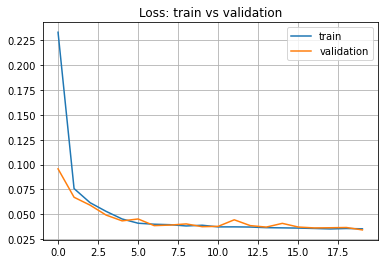

In [21]:
plt.plot(lstm_model.history.history['loss'], label='train')
plt.plot(lstm_model.history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.title('Loss: train vs validation')
plt.show()

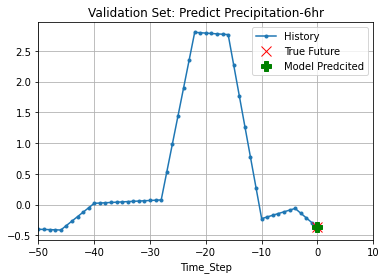

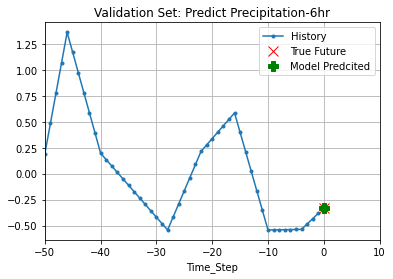

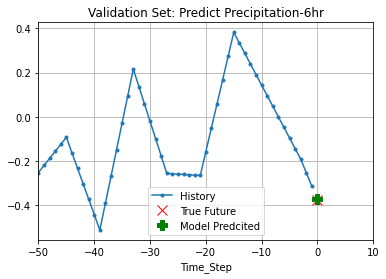

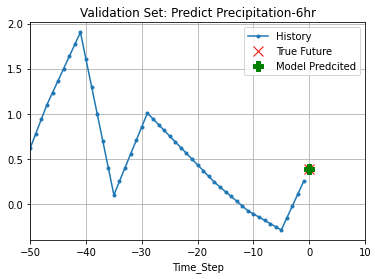

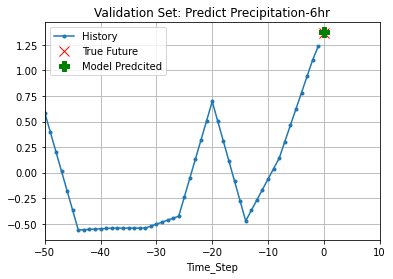

In [22]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'Validation Set: Predict Precipitation-6hr')
  plot.show()

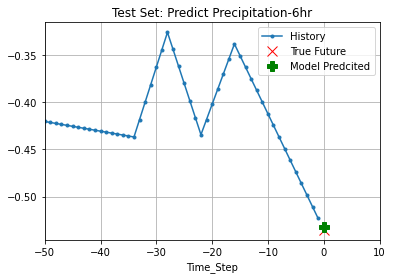

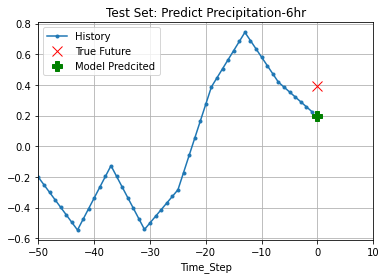

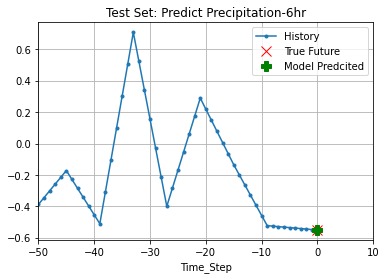

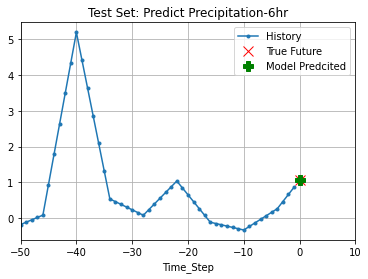

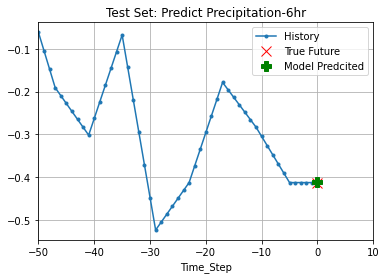

In [23]:
for i , j in test_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'Test Set: Predict Precipitation-6hr')
  plot.show()

# Train a model on all variables to predict precipitation 6hr



In [24]:
## features 
df_tot = pd.read_csv('/content/drive/MyDrive/Other/att/data_hawai.csv', index_col=0)
df_tot.sort_index(inplace=True) 
df_tot = df_tot.loc[(df_tot != -999).all(axis=1)]
df_tot = df_tot.groupby(level=0)['Temp','DewTemp','Pressure','WindDir','WindSpeed','CloudCover','Precip-1hr','Precip-6hr'].mean()
df_tot.interpolate(inplace=True)
df_tot.dropna(inplace=True)
features = ['Temp','DewTemp','Pressure','WindDir','WindSpeed','CloudCover','Precip-1hr','Precip-6hr']
features = df_tot[features]
features.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,Temp,DewTemp,Pressure,WindDir,WindSpeed,CloudCover,Precip-1hr,Precip-6hr
2017-01-01 00:00:00,215.727273,175.250000,10132.555556,62.222222,60.636364,5.500000,0.0,190.000
2017-01-01 01:00:00,220.000000,168.333333,10125.294118,75.294118,56.947368,2.000000,0.3,159.875
2017-01-01 02:00:00,219.684211,167.583333,10124.312500,101.764706,59.368421,2.000000,-0.1,129.750
2017-01-01 03:00:00,214.684211,162.833333,10129.312500,120.588235,56.210526,2.000000,3.2,99.625
2017-01-01 04:00:00,205.421053,164.166667,10135.250000,109.411765,50.315789,1.777778,-0.2,69.500


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6ebff8e90>,
      dtype=object)

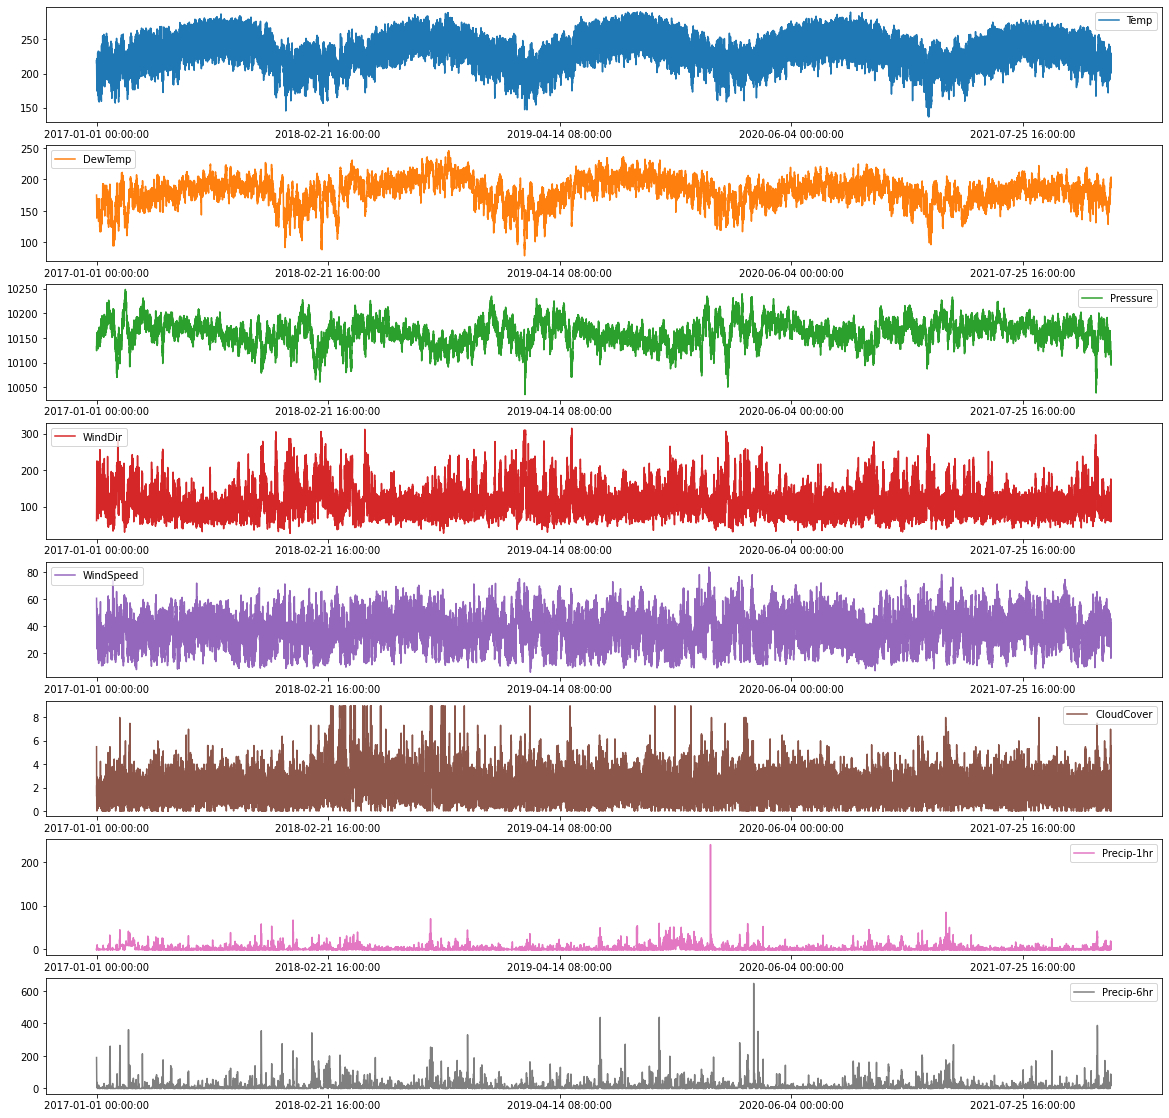

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
features.plot(ax=ax, subplots=True)


In [25]:
### standardize data
dataset = features.values
data_mean = dataset[:train_split].mean(axis =0)
data_std = dataset[:train_split].std(axis = 0)
dataset = (dataset - data_mean)/data_std

In [26]:
### generate multiple variable data
history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = create_multiple_variable_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = create_multiple_variable_data(dataset , dataset[:,1] , train_split , test_split , history ,
                                        future_target, STEP, single_step = True)

x_test_ss , y_test_ss = create_multiple_variable_data(dataset , dataset[:,1] , test_split , None , history ,
                                        future_target, STEP, single_step = True)

In [27]:
## tensorflow dataset
batch_size=32
buffer_size=500
train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

test_ss = tf.data.Dataset.from_tensor_slices((x_test_ss, y_test_ss))
test_ss = test_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()


In [28]:
### Modelling using LSTM

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(64, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.2))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = epochs, 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

Epoch 1/20
300/300 [==============================] - 22s 65ms/step - loss: 0.5563 - val_loss: 0.6253
Epoch 2/20
300/300 [==============================] - 19s 62ms/step - loss: 0.5282 - val_loss: 0.6446
Epoch 3/20
300/300 [==============================] - 19s 62ms/step - loss: 0.4517 - val_loss: 0.7111
Epoch 4/20
300/300 [==============================] - 19s 62ms/step - loss: 0.5007 - val_loss: 0.7282
Epoch 5/20
300/300 [==============================] - 19s 63ms/step - loss: 0.4824 - val_loss: 0.7995
Epoch 6/20
300/300 [==============================] - 19s 63ms/step - loss: 0.4035 - val_loss: 0.7451
Epoch 7/20
300/300 [==============================] - 19s 62ms/step - loss: 0.4957 - val_loss: 0.7775
Epoch 8/20
300/300 [==============================] - 19s 62ms/step - loss: 0.4387 - val_loss: 0.7954
Epoch 9/20
300/300 [==============================] - 19s 62ms/step - loss: 0.4462 - val_loss: 0.6982
Epoch 10/20
300/300 [==============================] - 19s 62ms/step - loss: 0.431

### Plot: time series and predicted values validation dataset


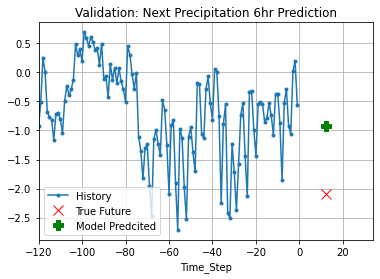

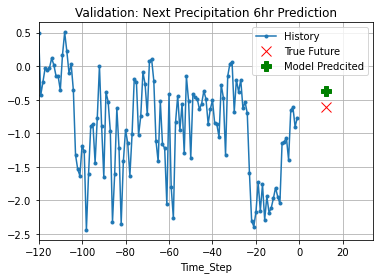

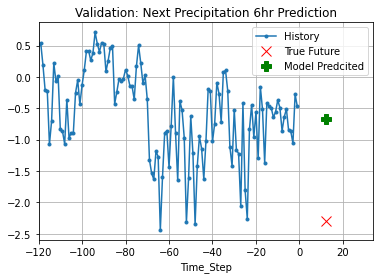

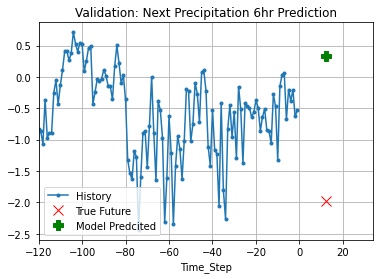

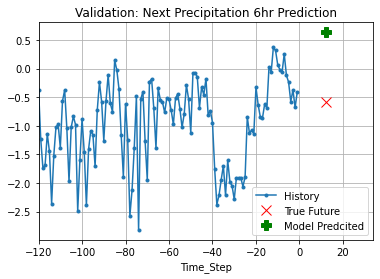

In [32]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Validation: Next Precipitation 6hr Prediction')
  plot.show()

### Plot: time series and predicted values test dataset


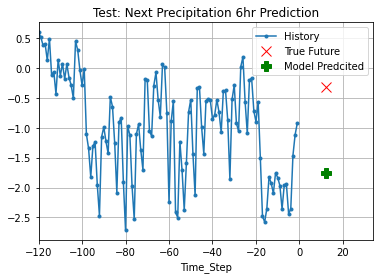

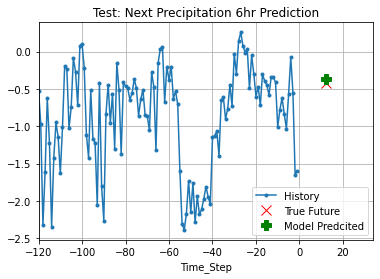

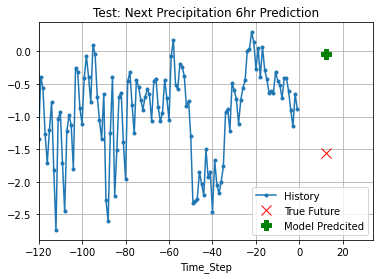

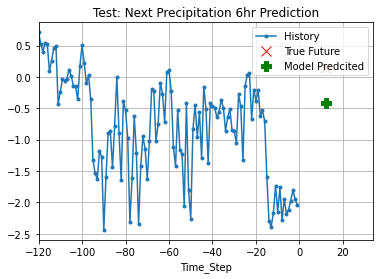

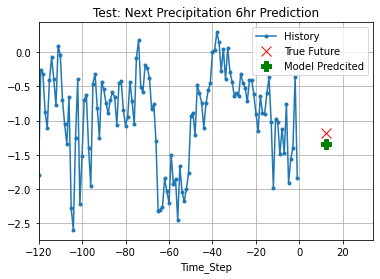

In [31]:
for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Test: Next Precipitation 6hr Prediction')
  plot.show()